In [1]:
import scipy.io
import numpy as np

from torch.utils.data import DataLoader
import deepclean_prod as dc
import torch
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt

# Loading & Formatting the data

In [2]:
file = scipy.io.loadmat('MLdata_L1HAM5_1381528818_4000_matrix_v2.mat')
data = file['data_matrix']
data.dtype
data.shape

(512000, 24)

In [3]:
dic = {}
channels = ['L1:ISI-GND_STS_ITMY_X_DQ','L1:ISI-GND_STS_ITMY_Y_DQ','L1:ISI-GND_STS_ITMY_Z_DQ','L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Y_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Z_IN_DQ','L1:ISI-HAM5_BLND_CPSRX_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRY_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRZ_IN1_DQ','L1:ISI-HAM5_BLND_GS13X_IN1_DQ']
#channels = ['L1:ISI-GND_STS_ITMY_X_DQ','L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ', 'L1:ISI-HAM5_BLND_CPSRX_IN1_DQ', 'L1:ISI-HAM5_BLND_GS13X_IN1_DQ']
for idx,c in enumerate(channels):
    print(idx, c)
    dic[c] = data[:,idx]

0 L1:ISI-GND_STS_ITMY_X_DQ
1 L1:ISI-GND_STS_ITMY_Y_DQ
2 L1:ISI-GND_STS_ITMY_Z_DQ
3 L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ
4 L1:ISI-HAM5_SCSUM_CPS_Y_IN_DQ
5 L1:ISI-HAM5_SCSUM_CPS_Z_IN_DQ
6 L1:ISI-HAM5_BLND_CPSRX_IN1_DQ
7 L1:ISI-HAM5_BLND_CPSRY_IN1_DQ
8 L1:ISI-HAM5_BLND_CPSRZ_IN1_DQ
9 L1:ISI-HAM5_BLND_GS13X_IN1_DQ


In [4]:
# skip first 100 seconds of data to be sure that everything is in a stable state
selc = {}
for c in channels:
    selc[c] = dic[c][100*128:]  

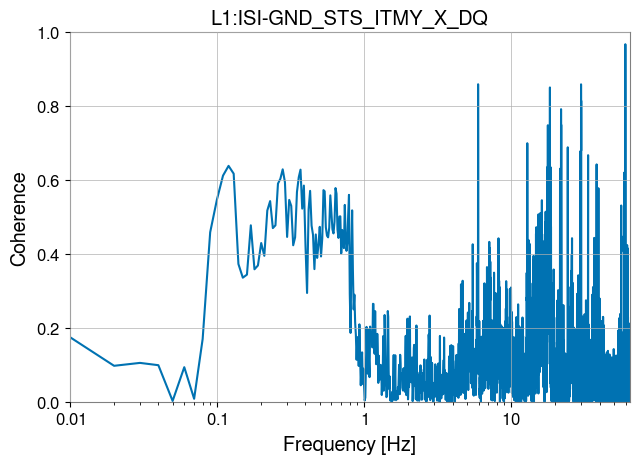

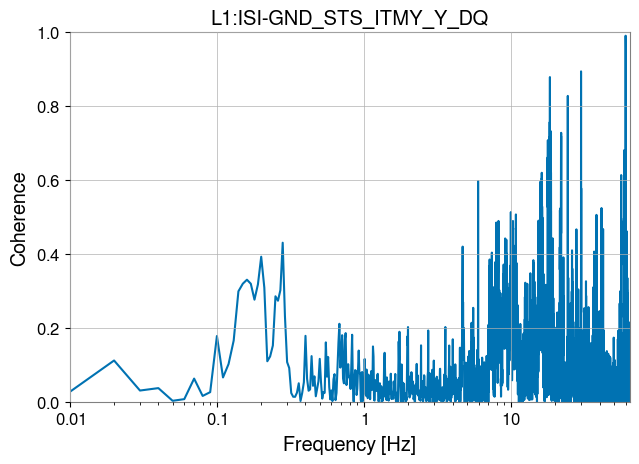

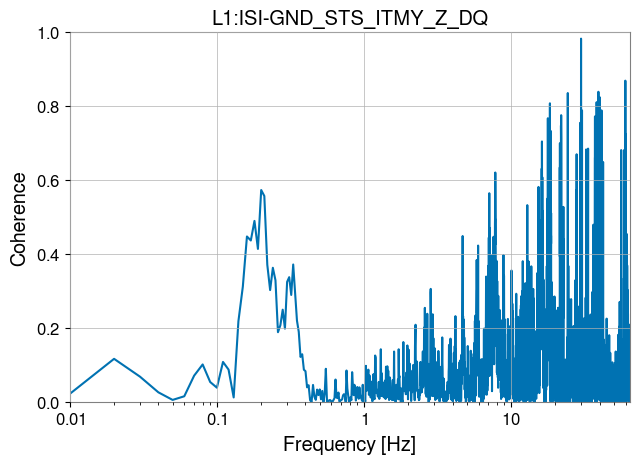

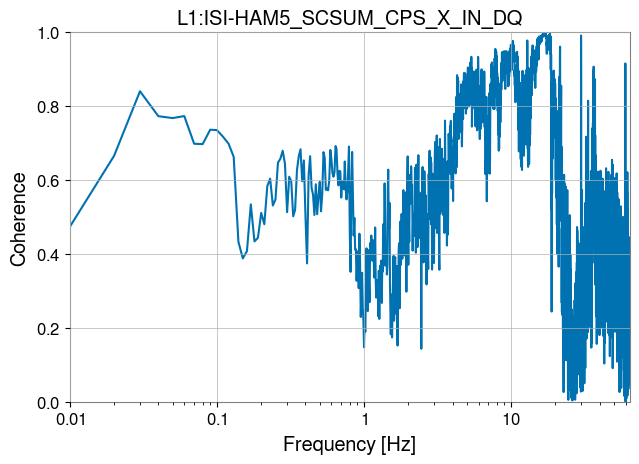

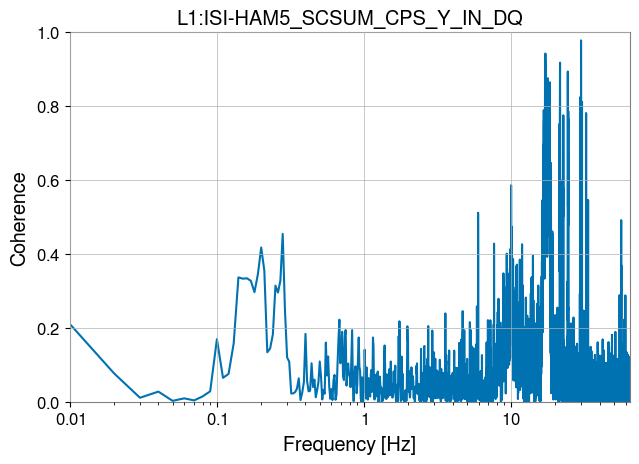

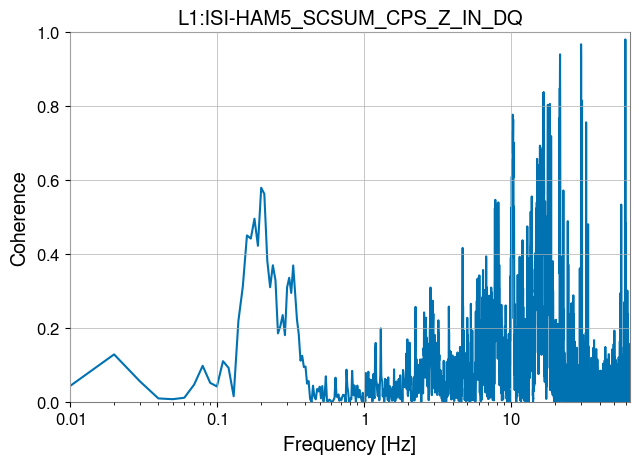

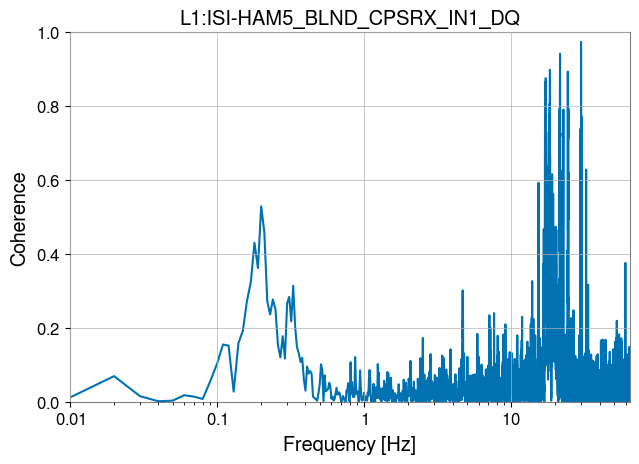

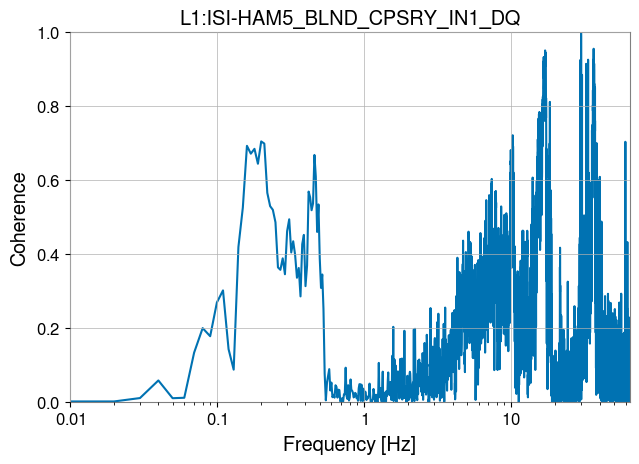

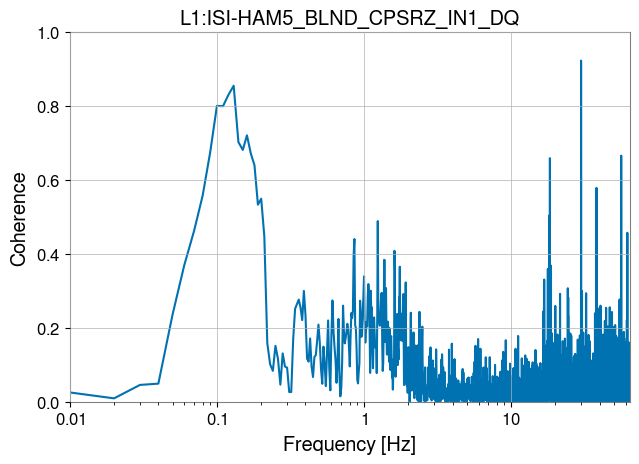

In [5]:
# Compute Coherence & Plot TimeSeries
strain = TimeSeries(selc['L1:ISI-HAM5_BLND_GS13X_IN1_DQ'], dt=1/128., t0=1381528818+100)
for c in channels[:-1]:
    d = TimeSeries(selc[c], dt=1/128., t0=1381528818+100)
    
    #fig = plt.figure()
    #d.plot()
    #plt.title(c)
    #plt.ylabel('A.U.')
    #plt.show()
    
    coh = strain.coherence(d, fftlength=100, overlap=1)
    plot = coh.plot(
    xlabel='Frequency [Hz]', xscale='log',
    ylabel='Coherence', yscale='linear', ylim=(0, 1),)
    plt.title(c)
    plot.show()
    
    

### ML specific preprocessing happens here

In [6]:
#channel_list = ['L1:ISI-HAM5_BLND_GS13X_IN1_DQ', 'L1:ISI-GND_STS_ITMY_X_DQ', 'L1:ISI-GND_STS_ITMY_Y_DQ', 'L1:ISI-GND_STS_ITMY_Z_DQ', 'L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Y_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Z_IN_DQ', 'L1:ISI-HAM5_BLND_CPSRX_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRY_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRZ_IN1_DQ']
channel_list = ['L1:ISI-HAM5_BLND_GS13X_IN1_DQ', 'L1:ISI-GND_STS_ITMY_X_DQ', 'L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ', 'L1:ISI-HAM5_BLND_CPSRX_IN1_DQ']

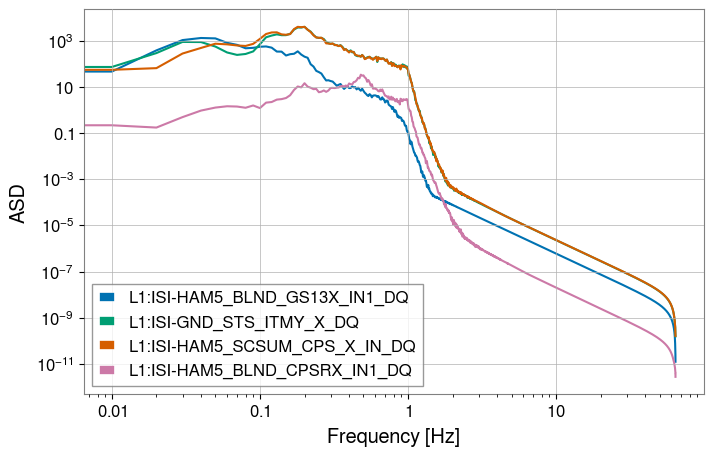

In [7]:
bandpass = True
flow = 0.03
fhigh = 1.0

for c in channel_list:
    ts = TimeSeries(selc[c], dt=1/128., t0=1381528818+100)
    if bandpass:
        ts = ts.bandpass(flow, fhigh)
        selc[c] = np.array(ts.value)
        
    ASD = ts.asd(fftlength=100,overlap=0.5,method='median')
    plt.loglog(ASD, label=c)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.legend()

In [8]:
l = [np.transpose(selc[c]) for c in channel_list]
data_prep = np.column_stack(l)

In [9]:
# split data in train and test set
n_sec = 3000
train_frac = 0.8
val_frac = 0.2

data_prep_ = np.transpose(data_prep)
train_data = data_prep_[:, :int(128*n_sec*train_frac)]
val_data = data_prep_[:, int(128*n_sec*train_frac):int(128*n_sec)]

# normalize data for training purposes
mean = train_data.mean(axis=-1, keepdims=True)
std = train_data.std(axis=-1, keepdims=True)
train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

print(train_data.shape, val_data.shape)

(4, 307200) (4, 76800)


# Training

Everything here is strongly influenced/ copied from the DeepClean setup as documented [here](https://git.ligo.org/tri.nguyen/deepclean-prod/-/tree/master?ref_type=heads)

In [10]:
class TimeSeriesSegmentDataset(Dataset):

    def __init__(self, data, kernel, stride, fs, pad_mode='median', target_idx=0):

        super().__init__()

        self.kernel = kernel
        self.stride = stride
        self.fs = fs
        self.pad_mode = pad_mode
        self.data = data
        self.target_idx = target_idx

    def __len__(self):
        """ Return the number of stride """
        nsamp = self.data.shape[-1]
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        n_stride = int(np.ceil((nsamp - kernel) / stride) + 1)
        return max(0, n_stride)

    def __getitem__(self, idx):
        """ Get sample Tensor for a given index """
        # check if idx is valid:
        if idx < 0:
            idx +=  self.__len__()
        if idx >= self.__len__():
            raise IndexError(
                f'index {idx} is out of bound with size {self.__len__()}.')

        # get sample
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        idx_start = idx * stride
        idx_stop = idx_start + kernel
        data = self.data[:, idx_start: idx_stop].copy()

        # apply padding if needed
        nsamp = data.shape[-1]
        if nsamp < kernel:
            pad = kernel - nsamp
            data = np.pad(data, ((0, 0), (0, pad)), mode=self.pad_mode)

        # separate into target strain and witnesses
        target = data[self.target_idx]
        aux = np.delete(data, self.target_idx, axis=0)

        # convert into Tensor
        target = torch.Tensor(target)
        aux = torch.Tensor(aux)

        return aux, target

In [11]:
train = TimeSeriesSegmentDataset(train_data, 50.0, 1.0, 128)
train_loader = DataLoader(train, 32, num_workers=4)
valid = TimeSeriesSegmentDataset(val_data, 50.0, 1.0, 128)
val_loader = DataLoader(valid, 32, num_workers=4)

#train = TimeSeriesSegmentDataset(train_data, 50.0, 1.0, 128)
#train_loader = DataLoader(train, 32, num_workers=4)
#valid = TimeSeriesSegmentDataset(val_data, 50.0, 1.0, 128)
#val_loader = DataLoader(valid, 32, num_workers=4)

In [12]:
# load model (DeepClean)
model = dc.nn.net.DeepClean(len(channel_list)-1)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)
model = model.to(device)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=4e-3, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=1, threshold= 0.001)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

# setup loss function (needs a bit of thoughts regarding FFT length, bandpass window etc.)
#criterion = dc.criterion.CompositePSDLoss(
#    128.0, 10.0, 15.0,
#    fftlength=2.0, overlap=None,
#    psd_weight=1.0, mse_weight=0.0,
#    reduction='sum', device=device)
criterion = torch.nn.MSELoss(reduction='mean')

cuda


In [36]:
# Actually start the training
train_logger = dc.logger.Logger(outdir='.', metrics=['loss'])
dc.nn.utils.train(
    train_loader, model, criterion, optimizer, lr_scheduler,
    val_loader=val_loader, max_epochs=25, logger=train_logger,
    device=device)

KeyboardInterrupt: 

In [64]:
np.sqrt(len(val_loader.dataset)/len(train_loader.dataset))

0.4841160541563984

## Plotting training progress

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
loss = np.loadtxt('metrics/loss.dat', skiprows=1, delimiter=',')
epochs = loss[:,1]
train_loss = loss[:,2]
valid_loss = loss[:,3]

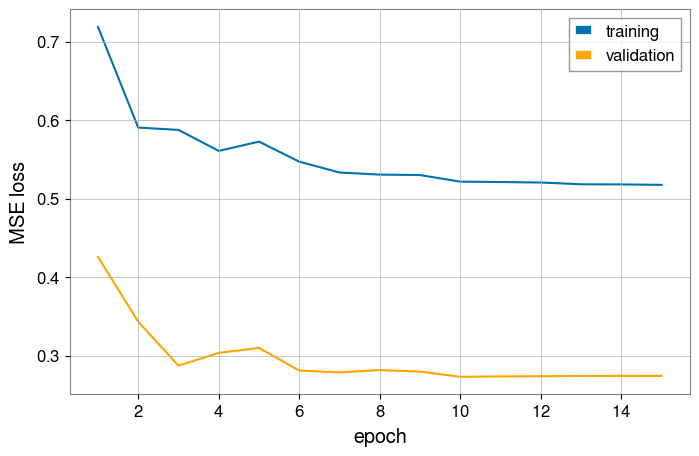

In [70]:
plt.plot(epochs, train_loss, label='training')
plt.plot(epochs, valid_loss, c='orange', label='validation')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Inference

test how well the model has actually learnt to predict `L1:ISI-HAM5_BLND_GS13X_IN1_DQ`

In [17]:
load_model = True
if load_model:
    model.load_state_dict(torch.load('./models/epoch_9',map_location=device))

In [18]:
# run inference
pred_batches = dc.nn.utils.evaluate(val_loader, model, device=device)
# postprocessing the ouput ('glue' together the individual predictions)
noverlap = int((50.0 - 1.0) * 128)
pred = dc.signal.overlap_add(pred_batches, noverlap, 'hanning')

# convert back to unit of target
pred *= std[0].ravel()
pred += mean[0].ravel()

true = val_data[0]*std[0].ravel() 
true += mean[0].ravel()


In [19]:
pred_batches.shape

(551, 6400)

In [20]:
N = 551
nperseg = 50*128

In [21]:
stride = nperseg - noverlap
print(stride)

128


In [22]:
int((N - 1) * stride + nperseg)

76800

In [23]:
val_data[0].shape

(76800,)

In [24]:
val_data[0].shape

(76800,)

In [25]:
pred.shape

(76800,)

In [26]:
true.shape

(76800,)

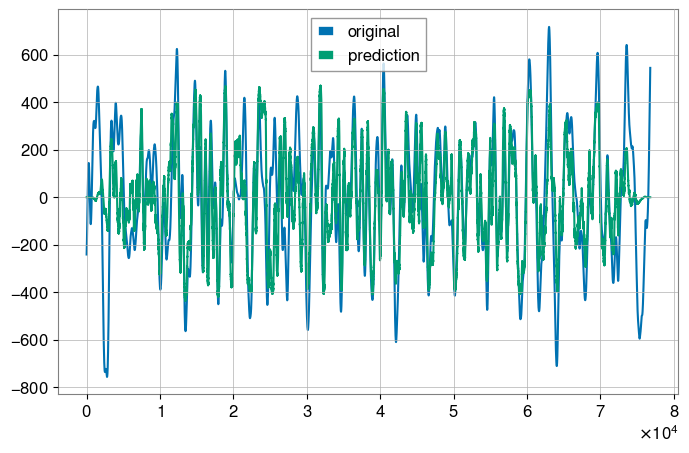

In [27]:
plt.plot(np.arange(0,76800,1), true, label='original')
plt.plot(np.arange(0,76800,1), pred, label='prediction')
plt.legend()

In [28]:
strain_org = TimeSeries(true, dt=1/128., t0=1381528818+900)
strain_pred = TimeSeries(pred, dt=1/128., t0=1381528818+900)
   
#coh = strain_org.coherence(strain_pred, fftlength=50, overlap=1)
#plot = coh.plot(
#    xlabel='Frequency [Hz]', xscale='log',
#    ylabel='Coherence', yscale='linear', ylim=(0, 1),color='orange')
#plot.show()

#strain_pred = ts.bandpass()

ASD_org = strain_org.asd(fftlength=200,overlap=0.5,method='median')
ASD_pred = strain_pred.asd(fftlength=200,overlap=0.5,method='median')

In [29]:
diff = strain_org - strain_pred
ASD_diff = diff.asd(fftlength=200,overlap=0.5,method='median')

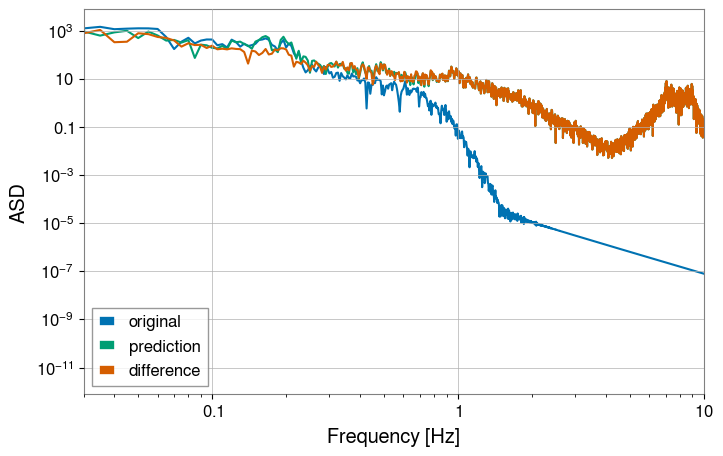

In [30]:
plt.loglog(ASD_org, label='original')
plt.loglog(ASD_pred, label='prediction')
plt.loglog(ASD_diff, label='difference')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.xlim([0.03,10.0])
plt.legend()

In [31]:
strain_pred_bp = strain_pred.bandpass(flow, fhigh)

In [32]:
print(fhigh)

1.0


In [33]:
strain_pred_bp.value

array([ 1.77077167e+01,  1.76673024e+01,  1.76268550e+01, ...,
       -7.66675654e-03, -6.50315699e-03, -5.48717441e-03])

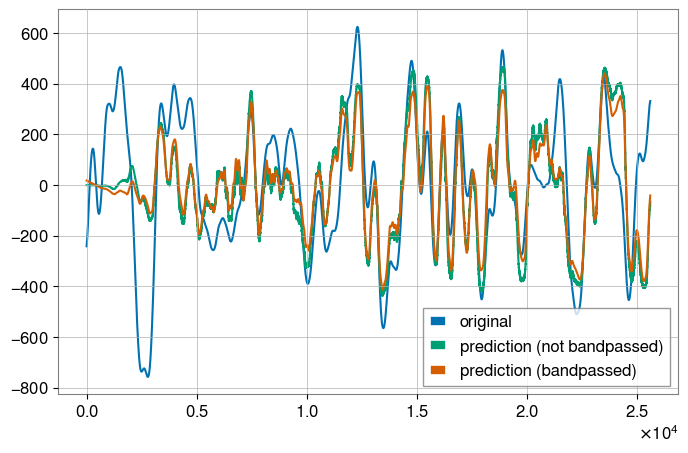

In [34]:
plt.plot(np.arange(0,200*128,1), true[:200*128], label='original')
plt.plot(np.arange(0,200*128,1), pred[:200*128], label='prediction (not bandpassed)')
plt.plot(np.arange(0,200*128,1), strain_pred_bp.value[:200*128], label='prediction (bandpassed)')
plt.legend()

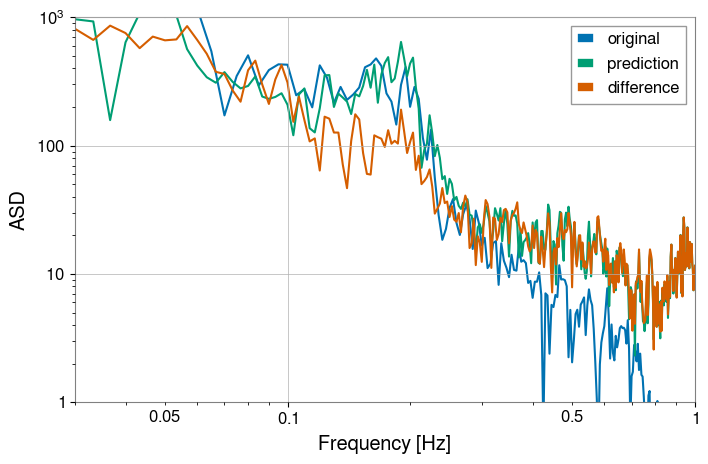

In [35]:
ASD_pred_bp = strain_pred_bp.asd(fftlength=300,overlap=0.5,method='median')
ASD_diff_bp = (strain_org - strain_pred_bp).asd(fftlength=300,overlap=0.5,method='median')

plt.loglog(ASD_org, label='original')
plt.loglog(ASD_pred_bp, label='prediction')
plt.loglog(ASD_diff_bp, label='difference')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.xlim([0.03,1.0])
plt.ylim([1, 10**3])
plt.legend()